In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import gc
import pickle

## Load data

In [2]:
%%time
# assign dtypes to reduce memory use
dtypes = {
    'click_id': 'uint32',
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8'
}
# attributed time is not read because it is not a feature of test data
train_df = pd.read_csv('input/train.csv', header=0, sep=',', 
                       dtype=dtypes, parse_dates=['click_time'],
                       usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'])

Wall time: 4min 46s


In [3]:
%%time
test_df = pd.read_csv('input/test.csv', header=0, sep=',', 
                       dtype=dtypes, parse_dates=['click_time'],
                       usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
gc.collect();

Wall time: 30.9 s


7

In [4]:
print('Loaded...')

Loaded...


## EDA

In [6]:
# data set sizes in rows
print("Train: "+str(len(train_df))+" rows")
print("Test:  "+str(len(test_df))+" rows")

Train: 184903890 rows
Test:  18790469 rows


In [11]:
# check out rows
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [19]:
train_df.tail()

,ip,app,device,os,channel,click_time,is_attributed
184903885,121312,12,1,10,340,2017-11-09 16:00:00,0
184903886,46894,3,1,19,211,2017-11-09 16:00:00,0
184903887,320126,1,1,13,274,2017-11-09 16:00:00,0
184903888,189286,12,1,37,259,2017-11-09 16:00:00,0
184903889,106485,11,1,19,137,2017-11-09 16:00:00,0


In [12]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [13]:
# unique categories
cols = ['ip', 'app', 'device', 'os', 'channel']
print('Train')
for col in cols:
    print('Number of unique '+col+': '+str(train_df[col].nunique()))
    
print('\nTest')
for col in cols:
    print('Number of unique '+col+': '+str(test_df[col].nunique()))

Train
Number of unique ip: 277396
Number of unique app: 706
Number of unique device: 3475
Number of unique os: 800
Number of unique channel: 202

Test
Number of unique ip: 93936
Number of unique app: 417
Number of unique device: 1985
Number of unique os: 395
Number of unique channel: 178


In [16]:
# proportion of attributed clicks in train
print("Proportion attributed: "+str(train_df.is_attributed.mean()))

Proportion attributed: 0.002470721410998979


Very few of the entries are attributed.

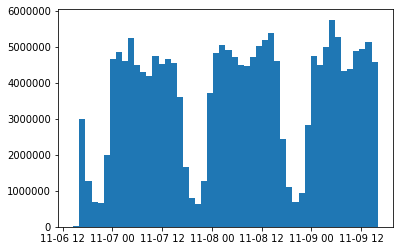

In [20]:
# check click times distribution
plt.hist(train_df.click_time, 50);

Click times for three consecutive days in train

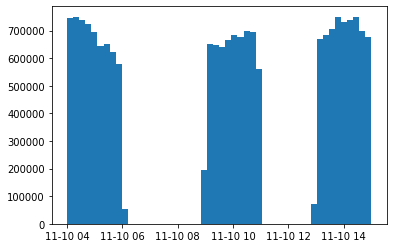

In [21]:
# check click times distribution
plt.hist(test_df.click_time, 50);

Forth day in test set.

Are the click times sorted?

In [10]:
train_df.click_time.is_monotonic, test_df.click_time.is_monotonic

(True, True)

click_time columns are sorted in the data frames

### Sanity checks

In [14]:
# dtypes
train_df.dtypes

ip                       uint32
app                      uint16
device                   uint16
os                       uint16
channel                  uint16
click_time       datetime64[ns]
is_attributed             uint8
dtype: object

In [15]:
test_df.dtypes

click_id              uint32
ip                    uint32
app                   uint16
device                uint16
os                    uint16
channel               uint16
click_time    datetime64[ns]
dtype: object

Make sure there are no NaN values.

In [7]:
train_df.isna().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

In [8]:
test_df.isna().sum()

click_id      0
ip            0
app           0
device        0
os            0
channel       0
click_time    0
dtype: int64